In [26]:
import sympy as smp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
path = os.getcwd()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0/255,34/255,78/255),(0.5,0.5,0.5),(253/255,230/255,54/255)])

In [27]:
from sympy import besselj, jn
from sympy.abc import x,y, n

y0, y1, y2, x0, x1, x2, l0, l1, l2 = smp.symbols('y_0,y_1,y_2,x_0,x_1,x_2,l_0,l_1,l_2', real=True)

# PSFs
b = 2*besselj(1, smp.sqrt((y-y0)**2+(x-x0)**2))**2/((x-x0)**2+(y-y0)**2) #Airy disk
#b = smp.cos((x-x0)/2)*smp.cos((y-y0)/2)/(1+0.2*((x-x0)**2+(y-y0)**2)) #Other artificial PSF
b_f = smp.lambdify( [x,y,x0,y0], b )

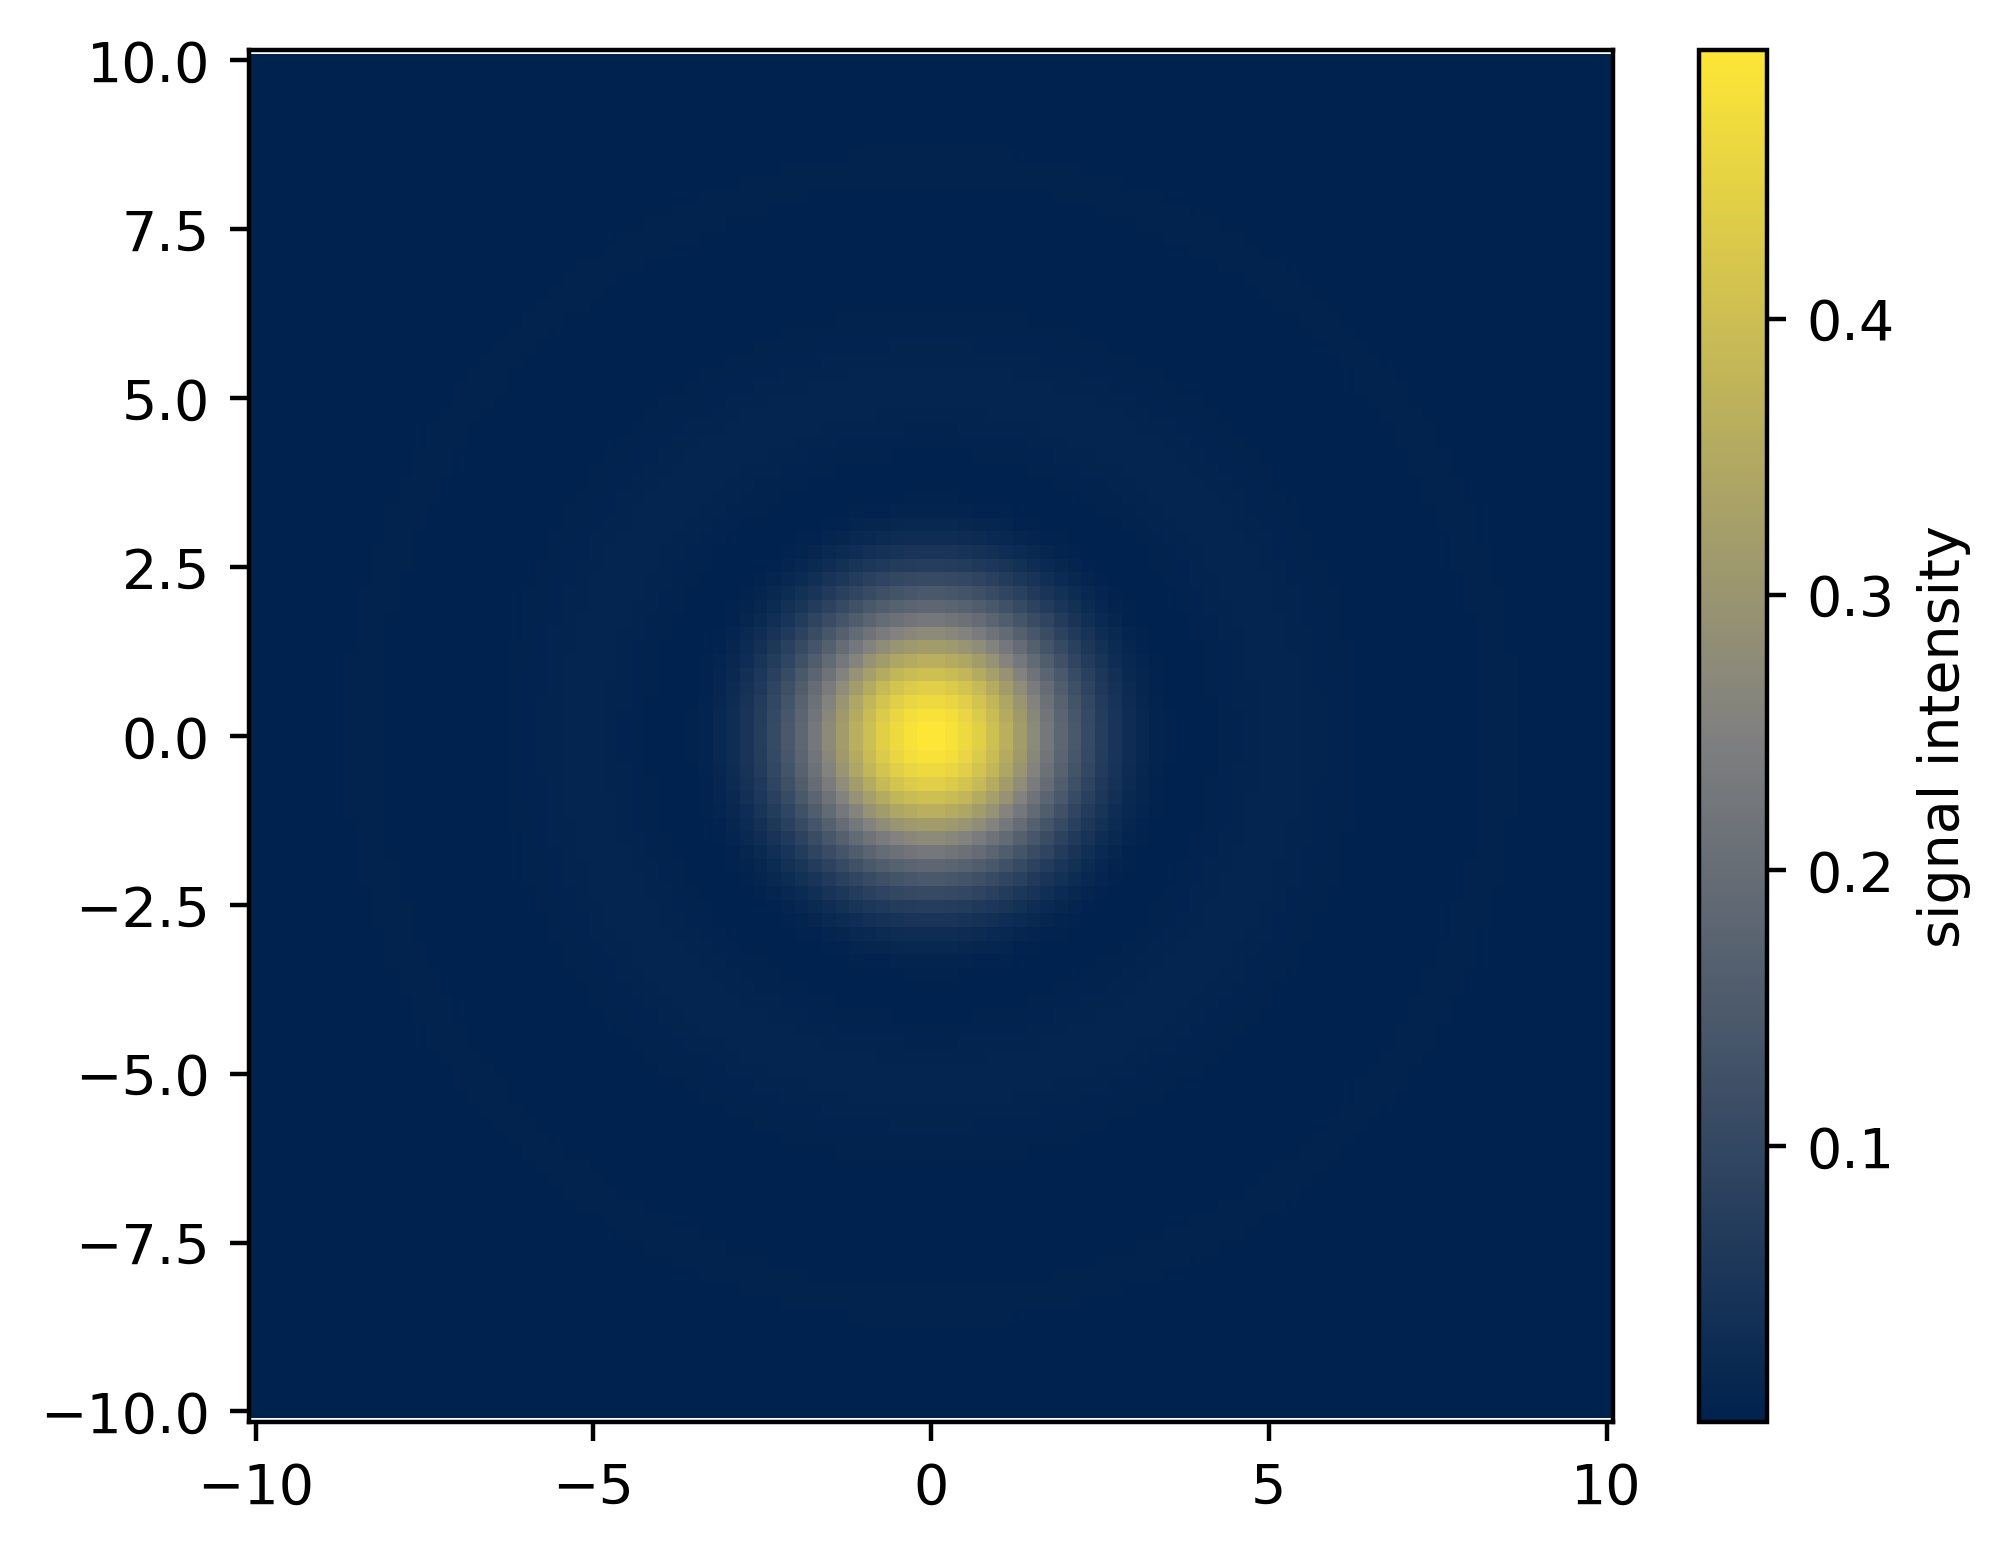

In [28]:
# Show the PSF of a single point source
fig, (ax0) = plt.subplots(1,1,figsize=(5.15,4), gridspec_kw={'height_ratios': [1]}, dpi=400)
x_fov = np.linspace(-10,10,100) 
y_fov = np.linspace(-10,10,100)
x_mesh, y_mesh = np.meshgrid(x_fov, y_fov)
pm = ax0.pcolormesh( x_mesh, y_mesh  , b_f(0,0,x_mesh,y_mesh) , cmap=cmap)
plt.colorbar(pm, label='signal intensity')
plt.tight_layout()
ax0.axis('equal')
plt.show()

In [35]:
#Analytic expressions of loss, grad(loss) and hess(loss)
loss = (l0*b.subs({x0:x0, y0:y0}) + l1*b.subs({x0:x1, y0:y1}) - l2*b.subs({x0:x2, y0:y2}))**2
grad = [loss.diff(x2), loss.diff(y2)]
hess = [grad[0].diff(x2) , grad[0].diff(y2) , grad[1].diff(y2)]

#Numeric functions
loss_f = smp.lambdify([x,y,x0,y0,x1,y1,x2,y2,l0,l1,l2] ,loss)
grad_f = smp.lambdify([x,y,x0,y0,x1,y1,x2,y2,l0,l1,l2] ,grad)
hess_f = smp.lambdify([x,y,x0,y0,x1,y1,x2,y2,l0,l1,l2] ,hess)


# field of view 
xs = np.linspace(-20,20,40)
ys = np.linspace(-20,20,40)


# total loss, grad and hessian (over the field of view)
def loss_func( x0,y0,x1,y1,x2,y2,l0,l1,l2  ):
    losses = [ [ loss_f( x,y, x0,y0,x1,y1,x2,y2,l0,l1,l2 ) for x in xs ] for y in ys]
    #trapeze
    loss = 0
    for i in range(xs.size-1):
        for j in range(ys.size-1):
            loss += (losses[j][i] + losses[j+1][i] + losses[j][i+1] + losses[j+1][i+1])/4
    return loss

def grad_func( x0,y0,x1,y1,x2,y2,l0,l1,l2 ):
    return np.sum([np.sum([ grad_f( x,y, x0,y0,x1,y1,x2,y2,l0,l1,l2 ) for x in xs ], axis=0) for y in ys],axis=0)

def hess_func( x0,y0,x1,y1,x2,y2,l0,l1,l2 ):
    return np.sum([np.sum([ hess_f( x,y, x0,y0,x1,y1,x2,y2,l0,l1,l2 ) for x in xs ],axis=0) for y in ys],axis=0)


In [43]:
# Algorithm to find best 1 point source (Q_star) that produce output similar to 2 given point sources (P)
def get_x_star( x0,y0,x1,y1,l0,l1 , plot=True):
    losses = []
    x2s = [x0,x1]
    y2s = [y0,y1]
    l2s = [l0,l1]
    for k in range(2):
        for i in range(5):
            Phitxi = np.sum( [[ l2s[k]*b_f(x,y,x2s[k],y2s[k])*(l0*b_f(x,y,x0,y0) + l1*b_f(x,y,x1,y1)) for x in xs ] for y in ys] )
            PhitPhi = np.sum( [[ l2s[k]*b_f(x,y,x2s[k],y2s[k])**2 for x in xs ] for y in ys] )
            l2s[k] = Phitxi/PhitPhi
            # grad/hess 1d
            grads = grad_func(x0,y0,x1,y1,x2s[k],y2s[k],l0,l1,l2s[k])
            hesss = hess_func(x0,y0,x1,y1,x2s[k],y2s[k],l0,l1,l2s[k])
            
            correction = 1/(hesss[0]*hesss[2]-hesss[1]**2)*np.array([ hesss[2]*grads[0]-hesss[1]*grads[1] , hesss[0]*grads[1]- hesss[1]*grads[0] ])
            
            x2s[k] = x2s[k] - correction[0]
            y2s[k] = y2s[k] - correction[1]
            
        losses.append( loss_func( x0,y0,x1,y1,x2s[k],y2s[k],l0,l1,l2s[k] ) )
    index = np.where(losses == np.min(losses))[0][0]
    
    DoverJ = (np.min( [ loss_func( x0,y0,x1,y1,x2s[index],y2s[index],l0,0,l2s[index] ), loss_func( x0,y0,x1,y1,x2s[index],y2s[index],0,l1,l2s[index] ) ] ) - loss_func( x0,y0,x1,y1,x2s[index],y2s[index],l0,l1,l2s[index] ) )/loss_func( x0,y0,x1,y1,x2s[index],y2s[index],l0,0,0 )
    
    if plot :
        fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1,5,figsize=(20,4), dpi=400)
        x_mesh, y_mesh = np.meshgrid(xs, ys)
        noise = np.random.normal(0,1, (xs.size,ys.size))
        pm = ax0.pcolormesh( x_mesh, y_mesh  , l0*b_f(x0,y0,x_mesh,y_mesh) + l1*b_f(x1,y1,x_mesh,y_mesh), cmap=cmap)
        ax0.title.set_text('P={p1,p2} without noise')
        pm = ax1.pcolormesh( x_mesh, y_mesh  , l0*b_f(x0,y0,x_mesh,y_mesh) + l1*b_f(x1,y1,x_mesh,y_mesh) + noise, cmap=cmap)
        ax1.title.set_text('P={p1,p2} with noise')
        pm = ax2.pcolormesh( x_mesh, y_mesh  , l2s[index]*b_f(x2s[index],y2s[index],x_mesh,y_mesh), cmap=cmap)
        ax2.title.set_text('Q_star without noise')
        pm = ax3.pcolormesh( x_mesh, y_mesh  , l0*b_f(x0,y0,x_mesh,y_mesh) + l1*b_f(x1,y1,x_mesh,y_mesh)- l2s[index]*b_f(x2s[index],y2s[index],x_mesh,y_mesh), cmap=cmap)
        ax3.title.set_text('P-Q_star without noise')
        pm = ax4.pcolormesh( x_mesh, y_mesh  , l0*b_f(x0,y0,x_mesh,y_mesh) + l1*b_f(x1,y1,x_mesh,y_mesh)- l2s[index]*b_f(x2s[index],y2s[index] ,x_mesh,y_mesh) + noise, cmap=cmap)
        ax4.title.set_text('P-Q_star with noise')
        plt.show()
        print( f'p_1 = (x = {x0}, y = {y0}, l = {l0})' ) 
        print( f'p_2 = (x = {x1}, y = {y1}, l = {l1})' ) 
        print( f'Q_star = (x = {x2s[index]}, y = {y2s[index]}, l = {l2s[index]})' ) 
        print(f'DoverJ = {DoverJ}',end='  ')
        if DoverJ>0:
              print('contamination')
        else:
              print('no contamination')
        print(f'J(P,Q_star) = {loss_func( x0,y0,x1,y1,x2s[index],y2s[index],l0,l1,l2s[index] )}')
        print(f'SNR = {np.sqrt(loss_func( x0,y0,x1,y1,x2s[index],y2s[index],l0,l1,0 ))}')
    
    
    return [x2s[index],y2s[index], l2s[index], (np.min( [ loss_func( x0,y0,x1,y1,x2s[index],y2s[index],l0,0,l2s[index] ), loss_func( x0,y0,x1,y1,x2s[index],y2s[index],0,l1,l2s[index] ) ] ) - loss_func( x0,y0,x1,y1,x2s[index],y2s[index],l0,l1,l2s[index] ) )/loss_func( x0,y0,x1,y1,x2s[index],y2s[index],l0,0,0 ),loss_func( x0,y0,x1,y1,x2s[index],y2s[index],l0,l1,l2s[index] ) ]



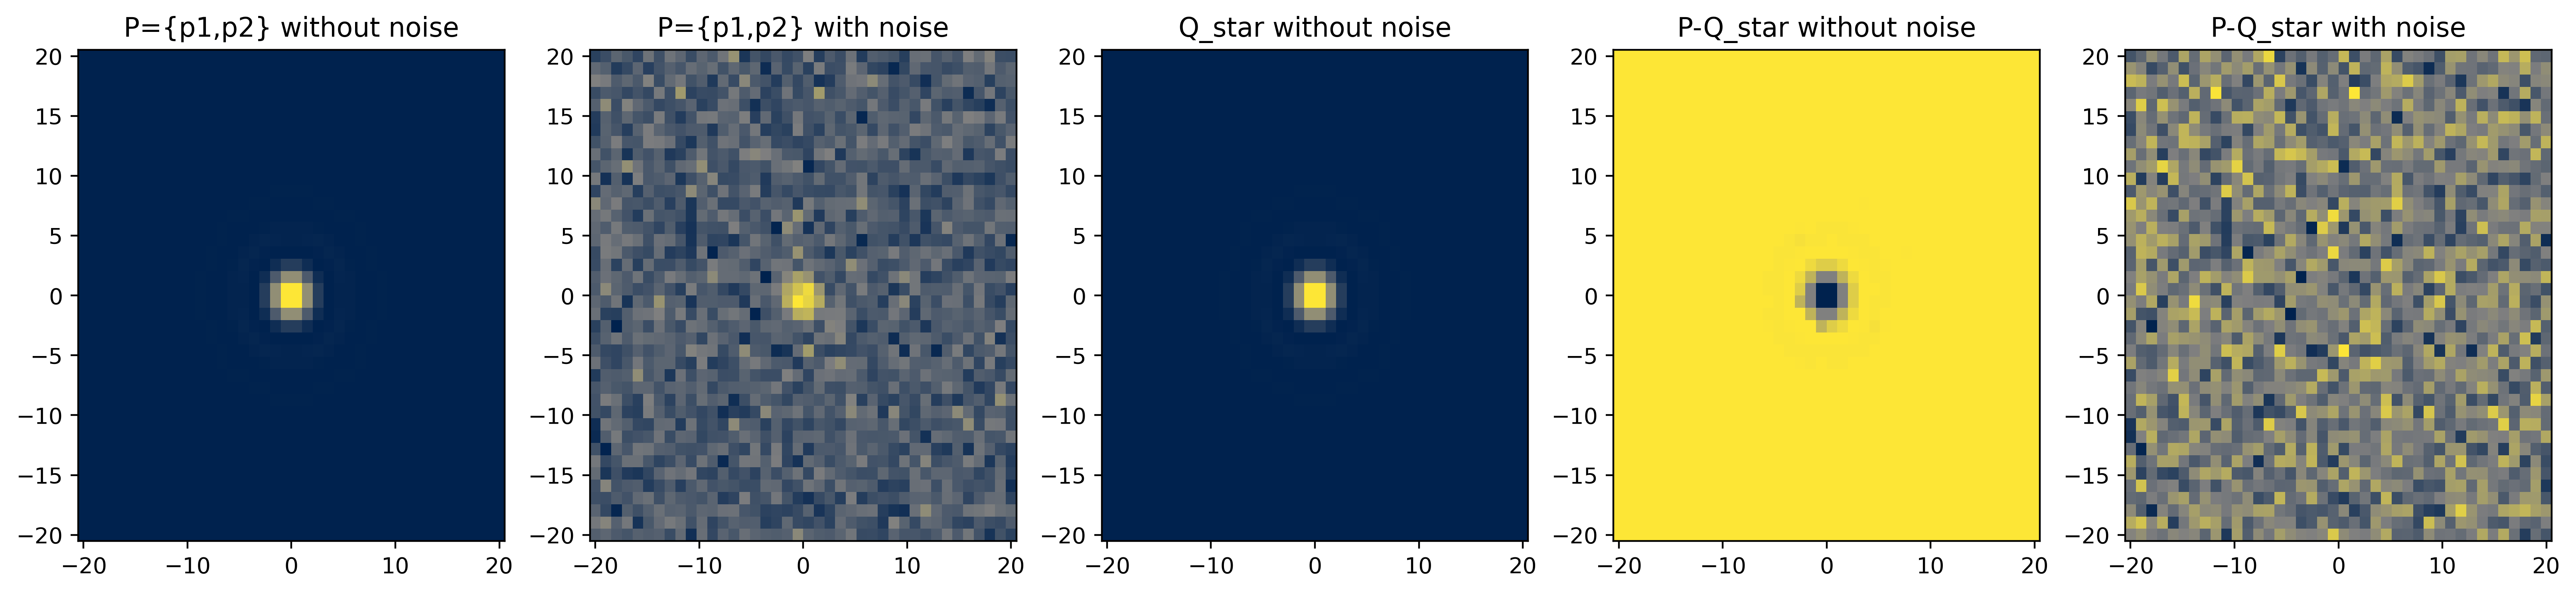

p_1 = (x = -0.0, y = 0, l = 7)
p_2 = (x = 0.0, y = 0, l = 7)
Q_star = (x = 2.619909709148848e-17, y = 2.6199097091488456e-17, l = 14.000000000000002)
DoverJ = 1.0000000000000002  contamination
J(P,Q_star) = 6.323003428811737e-30
SNR = 16.402368672389322


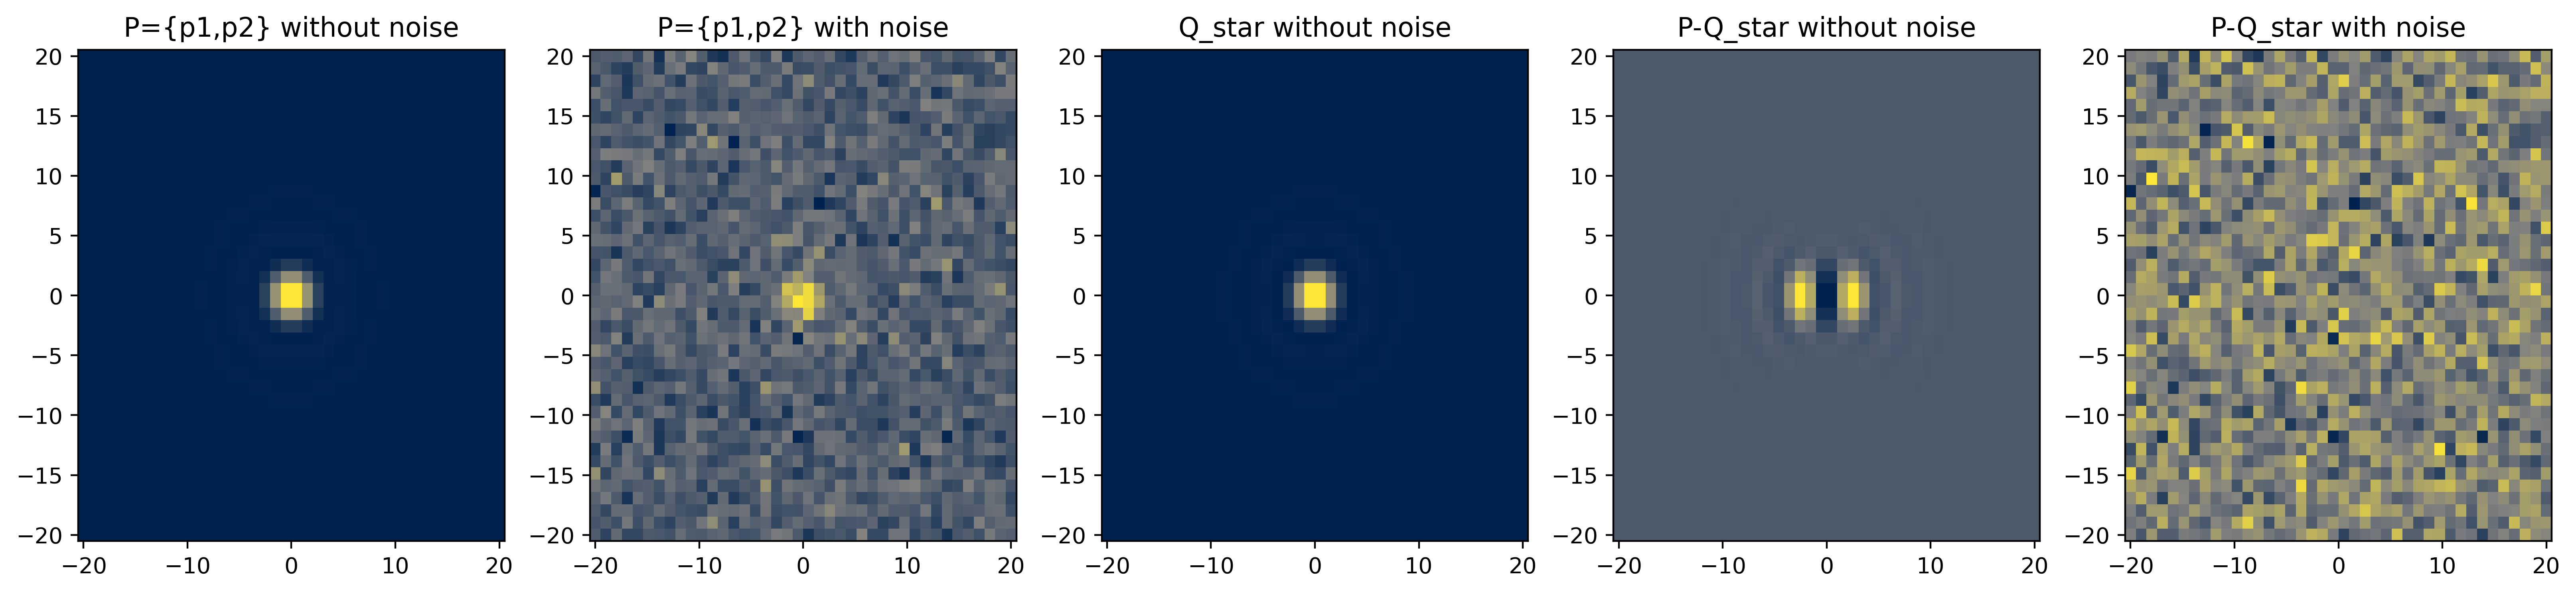

p_1 = (x = -0.35714285714285715, y = 0, l = 7)
p_2 = (x = 0.35714285714285715, y = 0, l = 7)
Q_star = (x = 2.673460350005682e-17, y = -4.475196869547931e-17, l = 13.731006327624431)
DoverJ = 0.997322606347978  contamination
J(P,Q_star) = 0.1800786596829828
SNR = 16.09281234417768


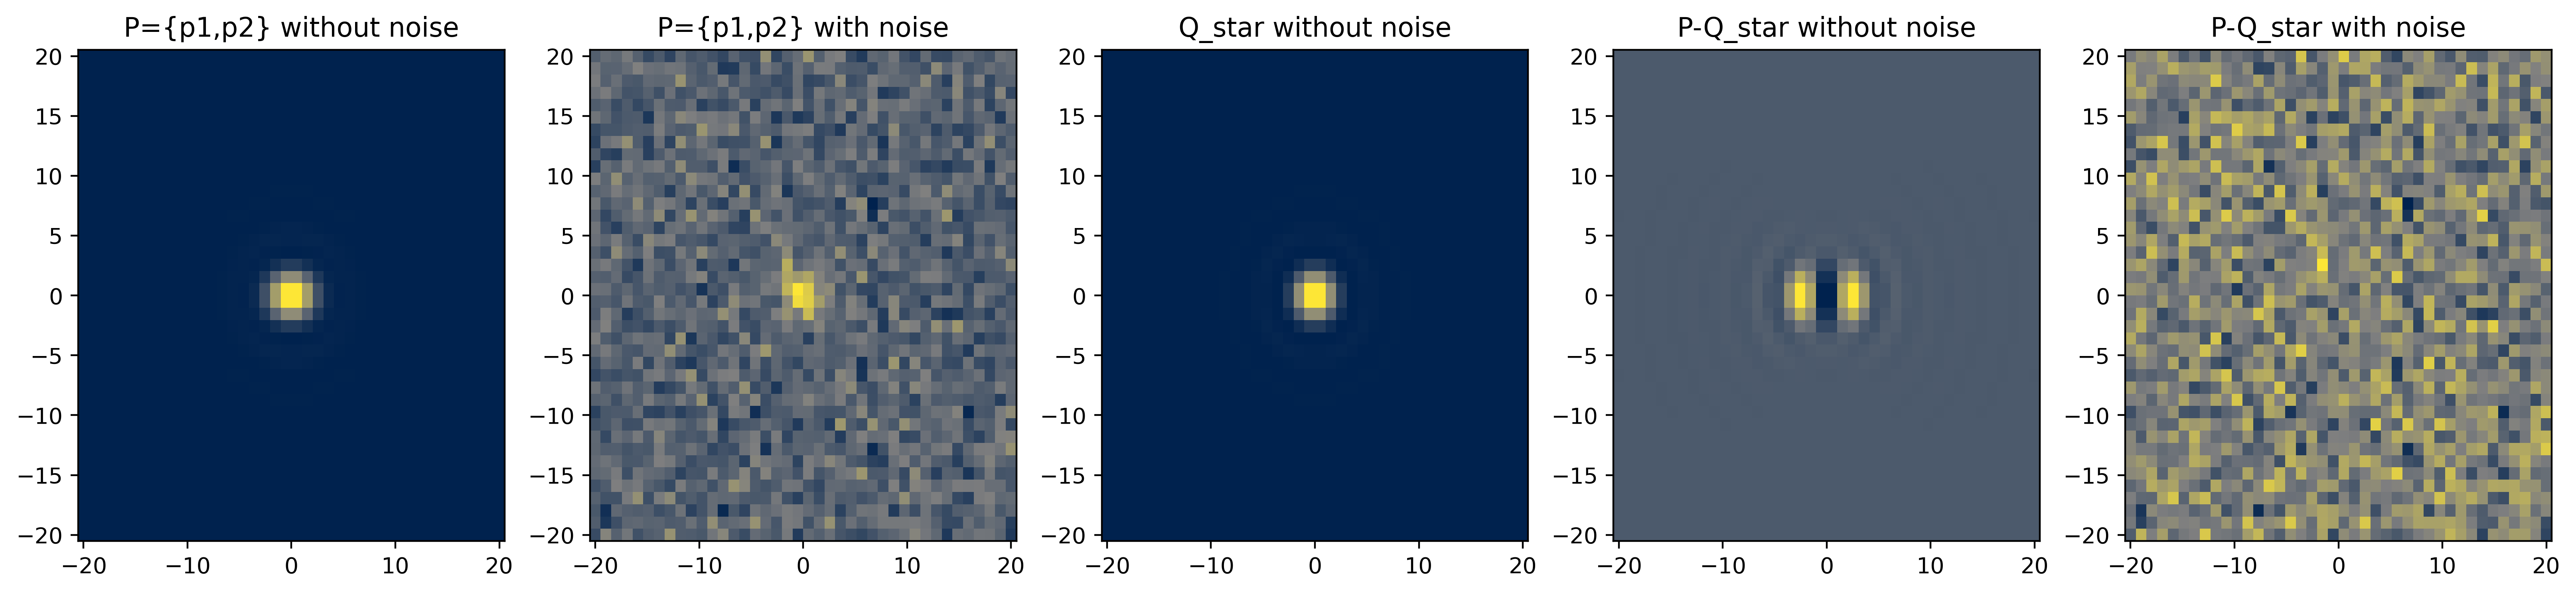

p_1 = (x = -0.7142857142857143, y = 0, l = 7)
p_2 = (x = 0.7142857142857143, y = 0, l = 7)
Q_star = (x = 1.8229888665223295e-16, y = -2.064219408934141e-18, l = 12.95310375441268)
DoverJ = 0.9611503149936292  contamination
J(P,Q_star) = 2.613003503450534
SNR = 15.261675793207914


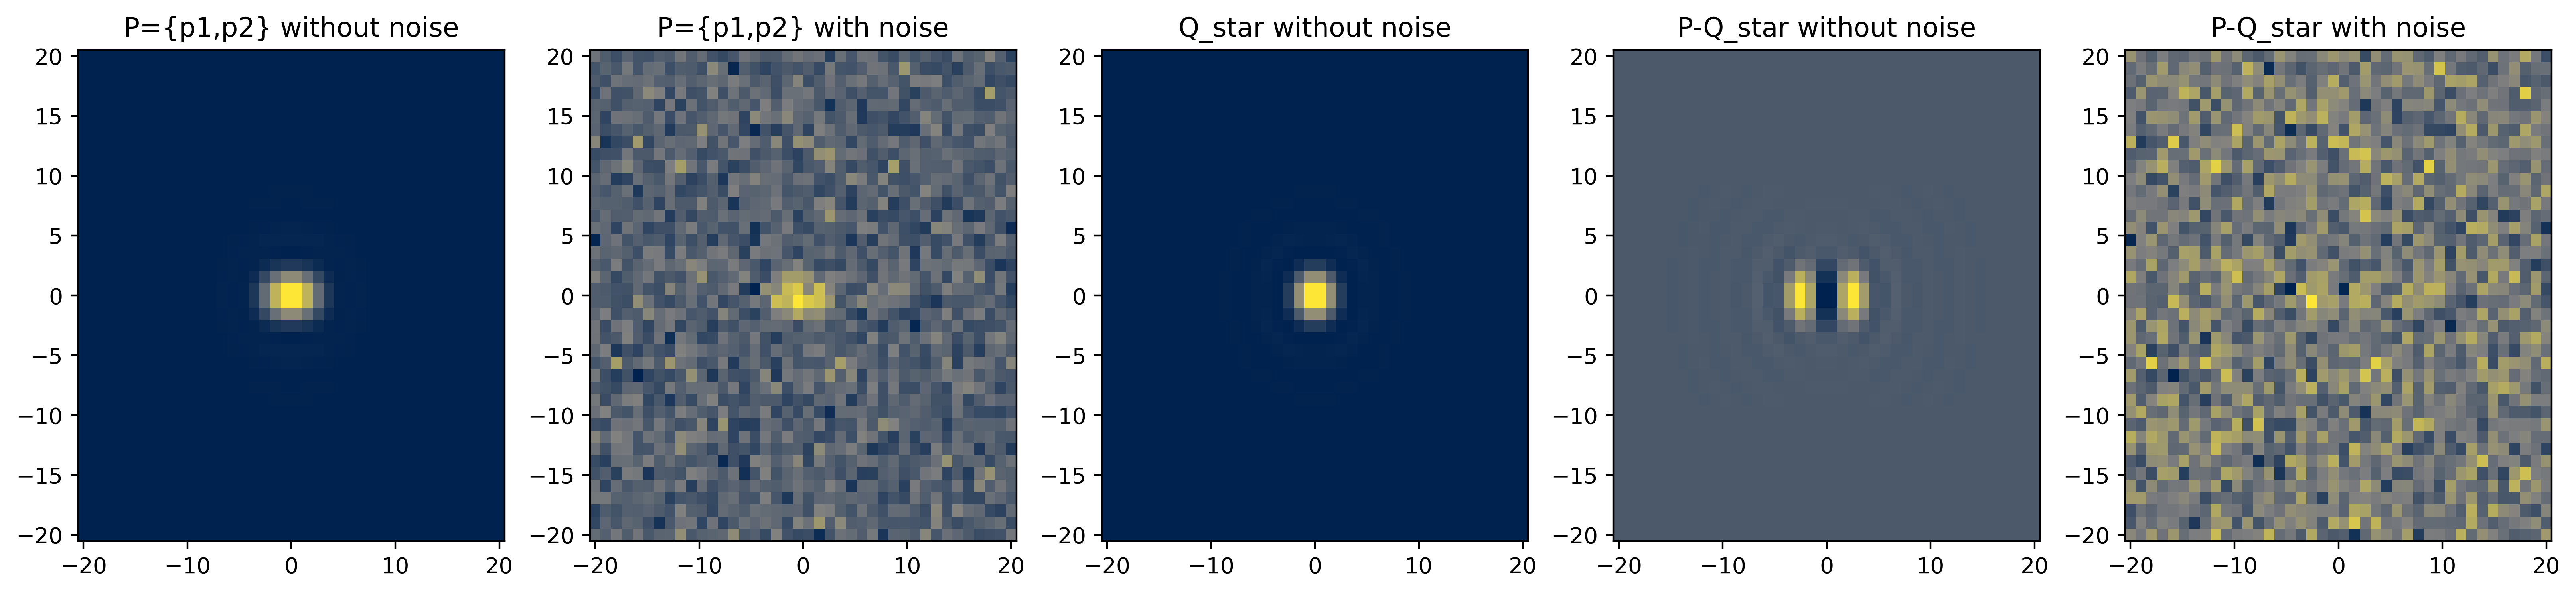

p_1 = (x = -1.0714285714285714, y = 0, l = 7)
p_2 = (x = 1.0714285714285714, y = 0, l = 7)
Q_star = (x = 1.0305070734794315e-16, y = 1.3730062310991917e-16, l = 11.748815648012508)
DoverJ = 0.8326297417772078  contamination
J(P,Q_star) = 11.257221996754119
SNR = 14.167897627404223


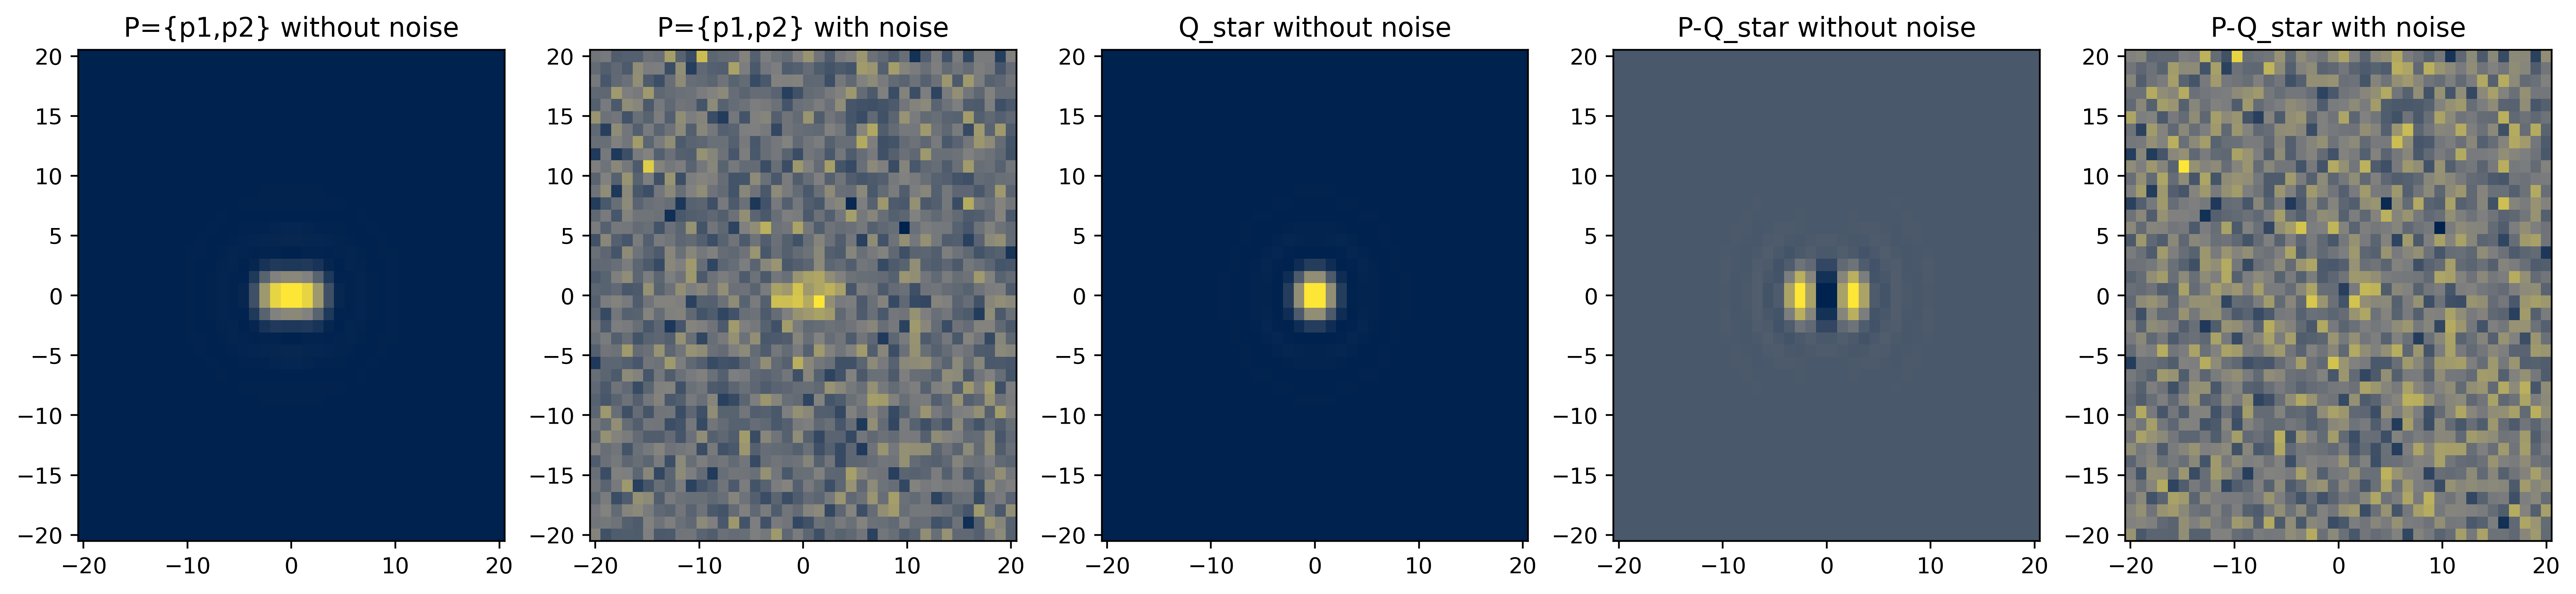

p_1 = (x = -1.4285714285714286, y = 0, l = 7)
p_2 = (x = 1.4285714285714286, y = 0, l = 7)
Q_star = (x = -9.740238348173476e-19, y = -6.405472167082459e-17, l = 10.240932901938173)
DoverJ = 0.5764459290927023  contamination
J(P,Q_star) = 28.48799914319511
SNR = 13.131873751217714


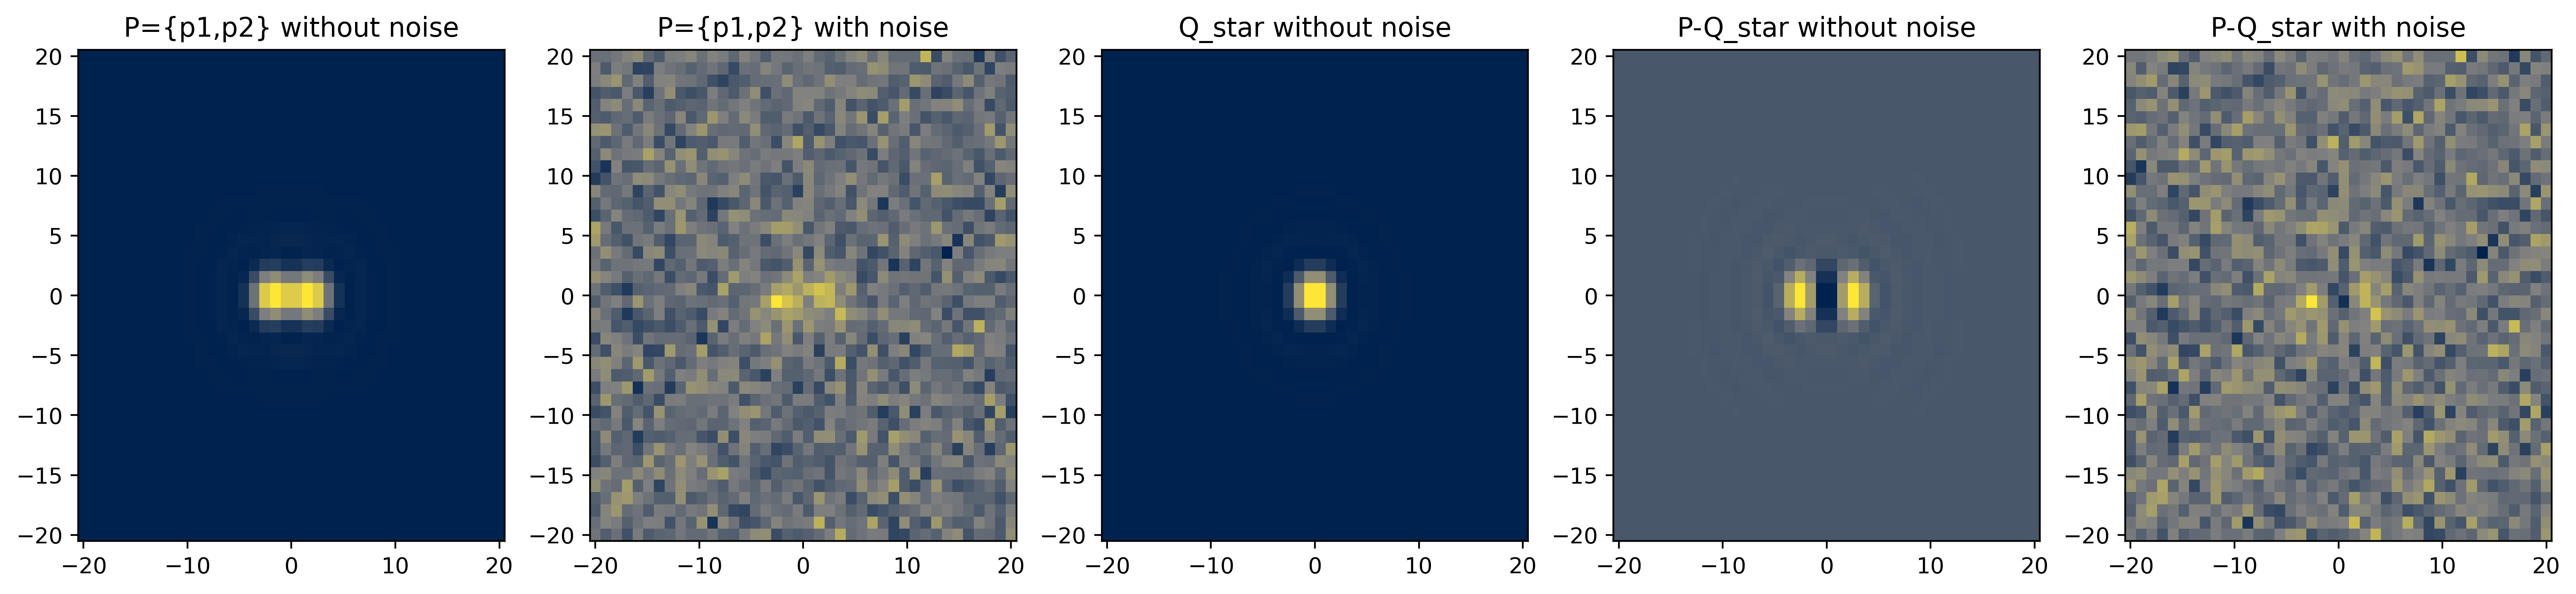

p_1 = (x = -1.7857142857142858, y = 0, l = 7)
p_2 = (x = 1.7857142857142858, y = 0, l = 7)
Q_star = (x = 1.7958049539520266e-05, y = -8.364195735936285e-17, l = 8.57350558801442)
DoverJ = 0.21726202959164642  contamination
J(P,Q_star) = 52.645321716014024
SNR = 12.391193318239416


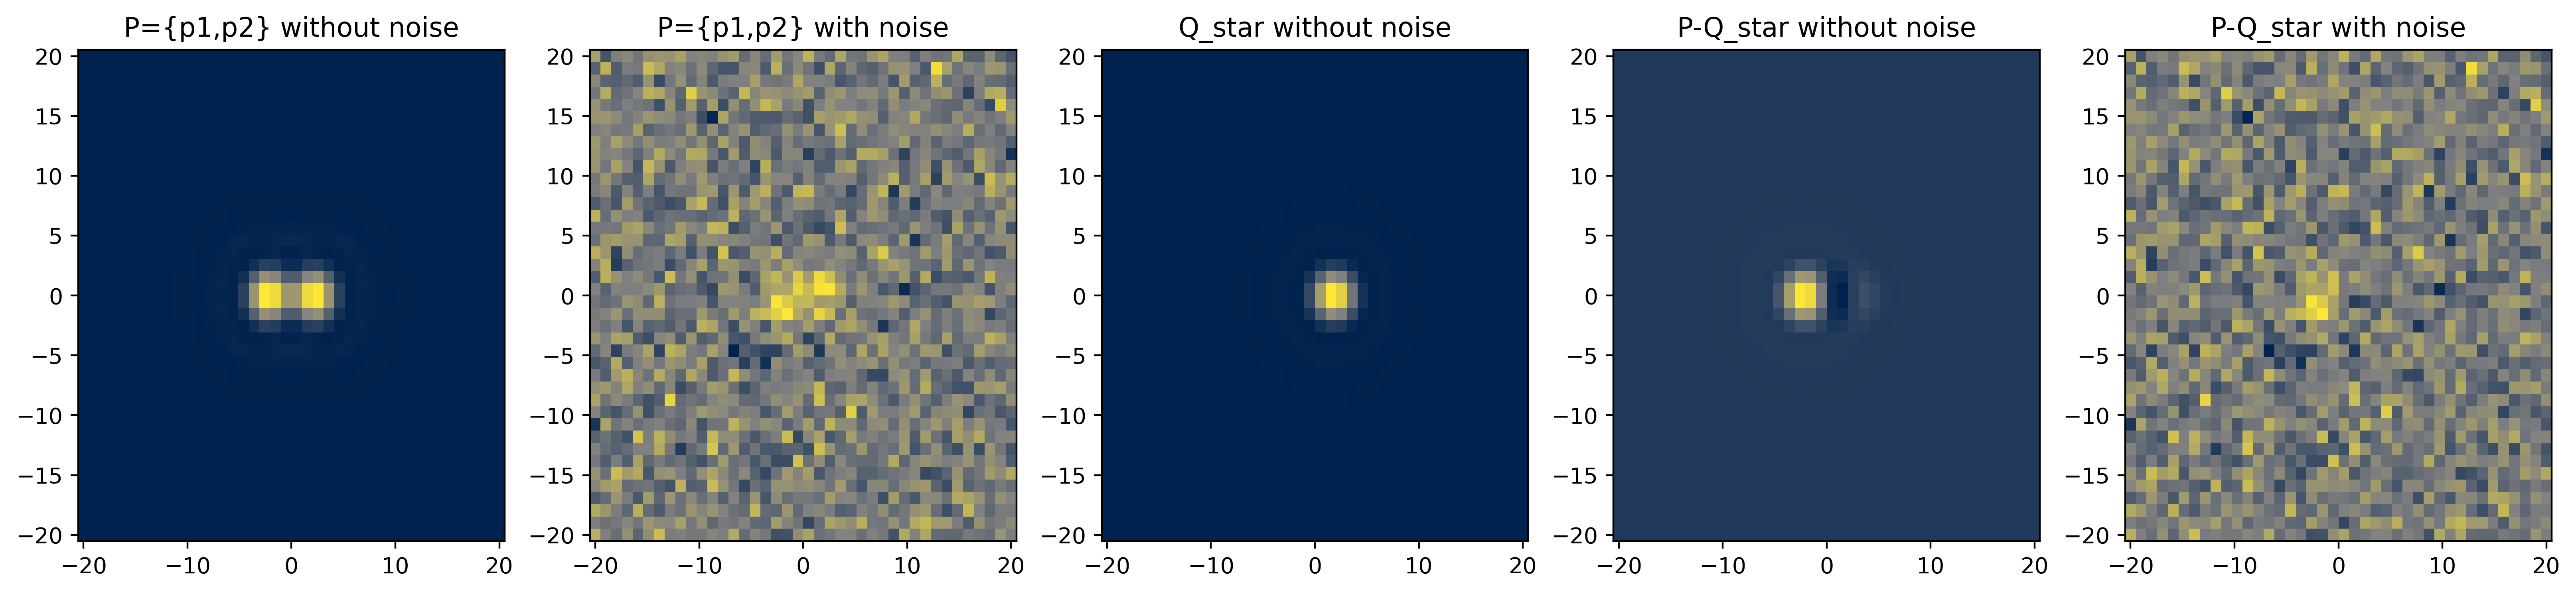

p_1 = (x = -2.142857142857143, y = 0, l = 7)
p_2 = (x = 2.142857142857143, y = 0, l = 7)
Q_star = (x = 1.8291681824244999, y = 1.9899295728824135e-16, l = 7.554220936248625)
DoverJ = -0.9361863475163058  no contamination
J(P,Q_star) = 65.54528436846213
SNR = 11.994863617605946


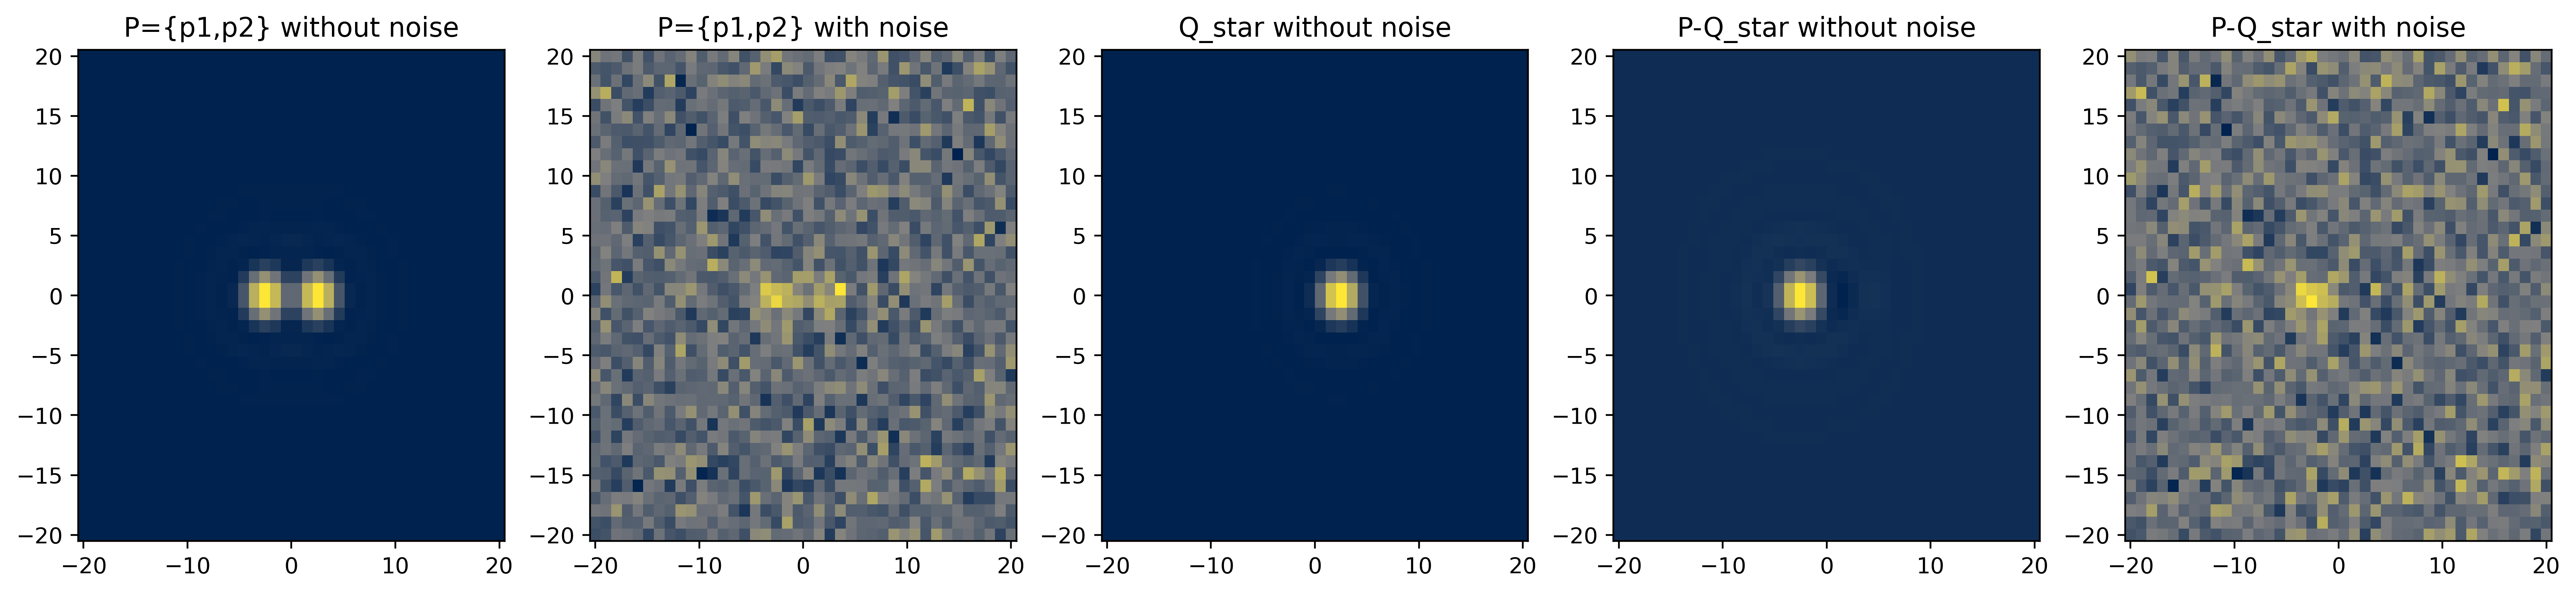

p_1 = (x = -2.5, y = 0, l = 7)
p_2 = (x = 2.5, y = 0, l = 7)
Q_star = (x = 2.41485218943659, y = 5.3743759852547204e-17, l = 7.294051467628573)
DoverJ = -0.992227730618856  no contamination
J(P,Q_star) = 67.00975158071687
SNR = 11.833791182311325


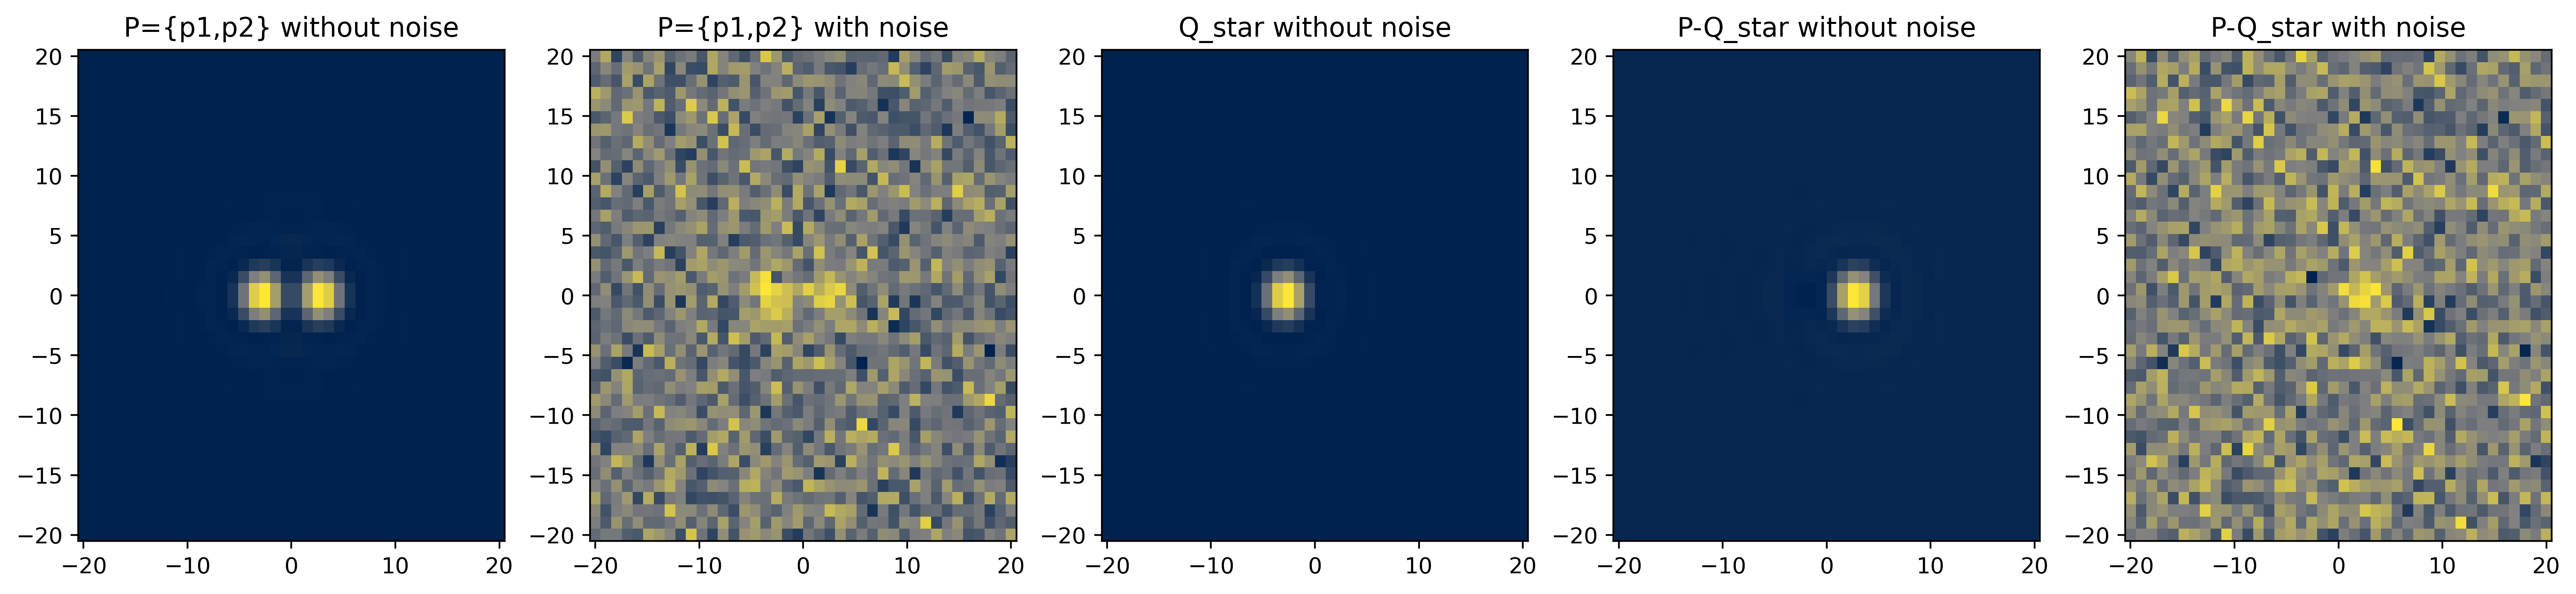

p_1 = (x = -2.857142857142857, y = 0, l = 7)
p_2 = (x = 2.857142857142857, y = 0, l = 7)
Q_star = (x = -2.818460925716457, y = 1.2029728166230799e-16, l = 7.2103883046975)
DoverJ = -0.9972784072650164  no contamination
J(P,Q_star) = 67.16862182412432
SNR = 11.769952772167127


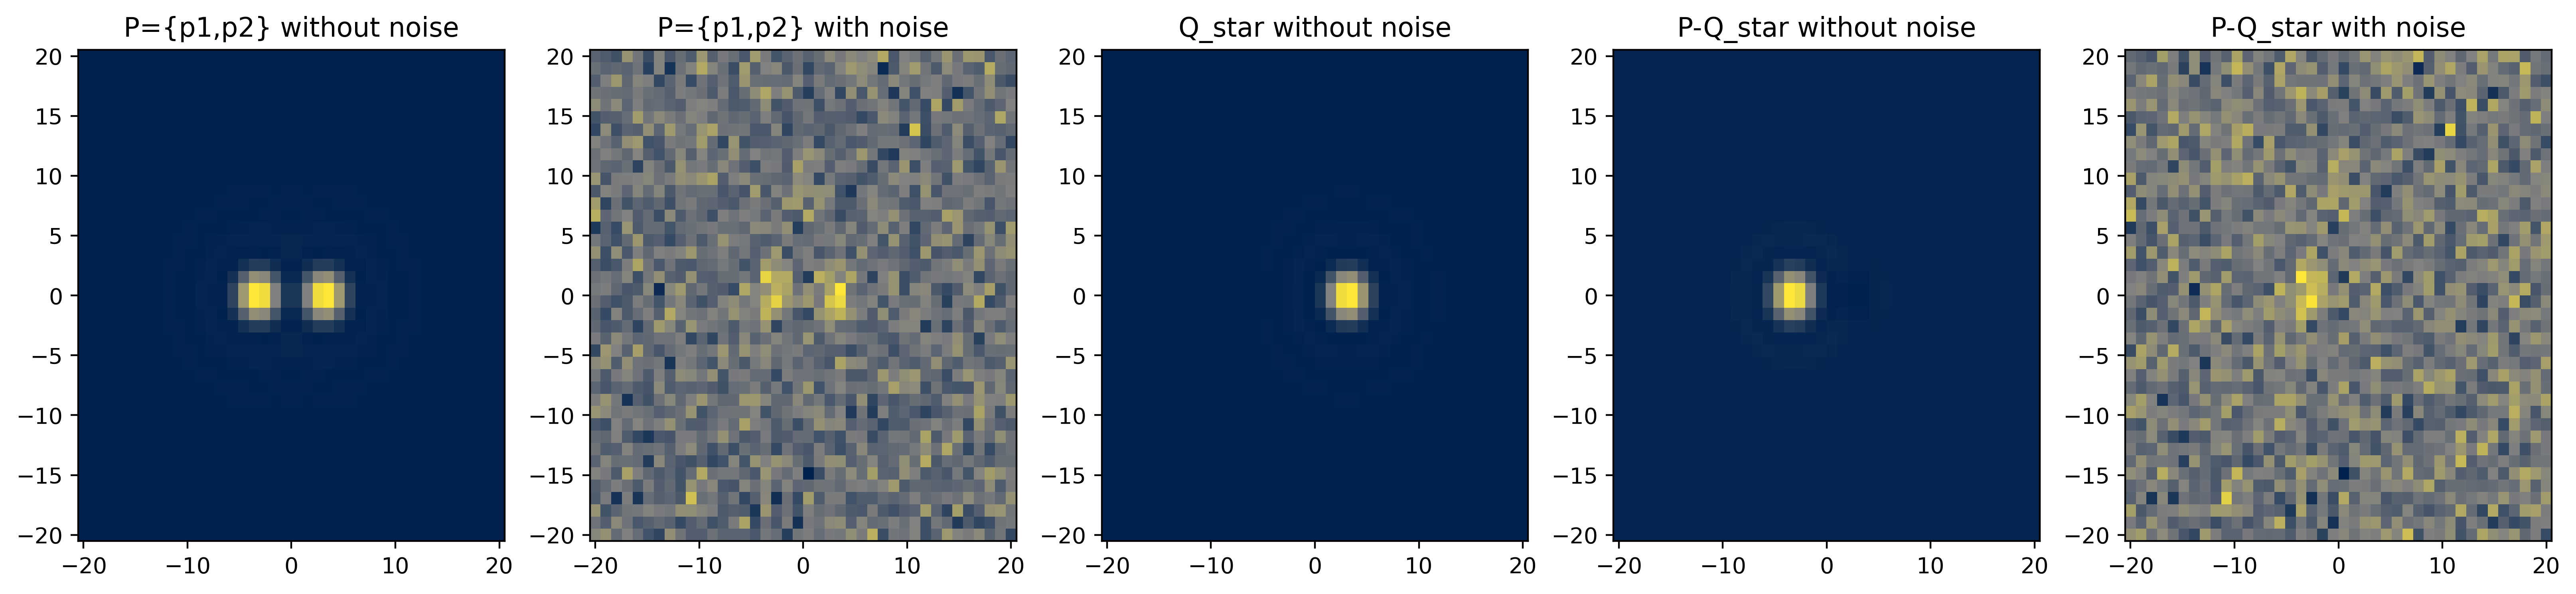

p_1 = (x = -3.2142857142857144, y = 0, l = 7)
p_2 = (x = 3.2142857142857144, y = 0, l = 7)
Q_star = (x = 3.1809188025847885, y = -5.1269851038879327e-17, l = 7.156934738191027)
DoverJ = -0.9983116984675036  no contamination
J(P,Q_star) = 67.20292289875833
SNR = 11.726547146162526


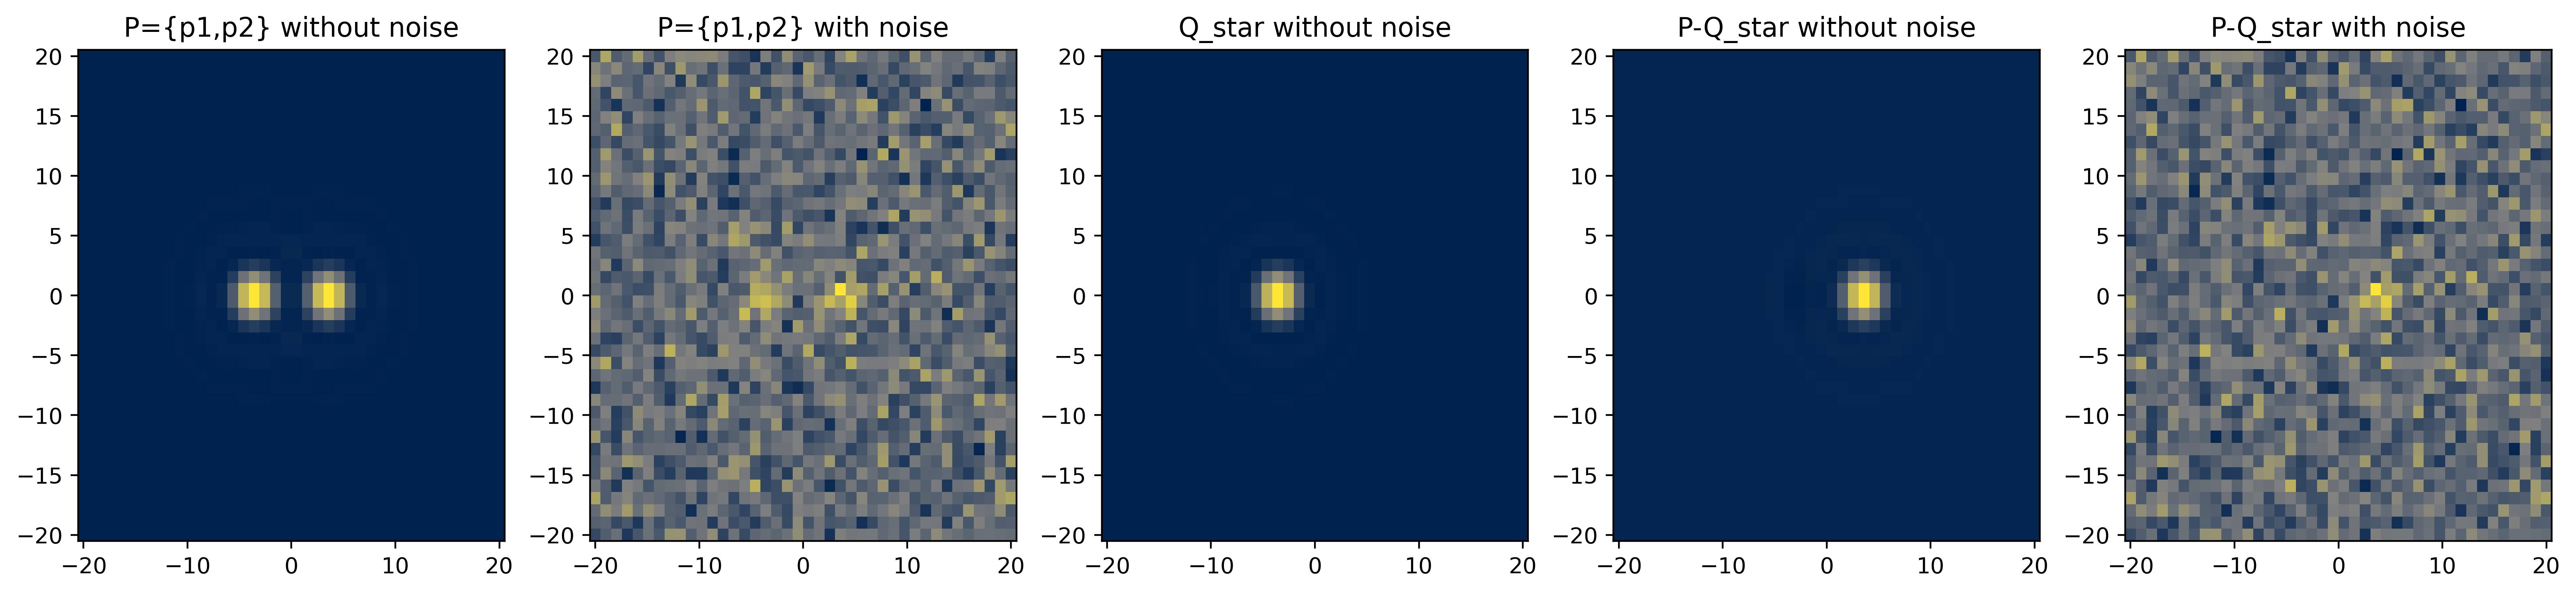

p_1 = (x = -3.5714285714285716, y = 0, l = 7)
p_2 = (x = 3.5714285714285716, y = 0, l = 7)
Q_star = (x = -3.544532443811442, y = 2.4363780663088335e-16, l = 7.1101781400407305)
DoverJ = -0.9990643036255179  no contamination
J(P,Q_star) = 67.22814294070567
SNR = 11.688518262761228


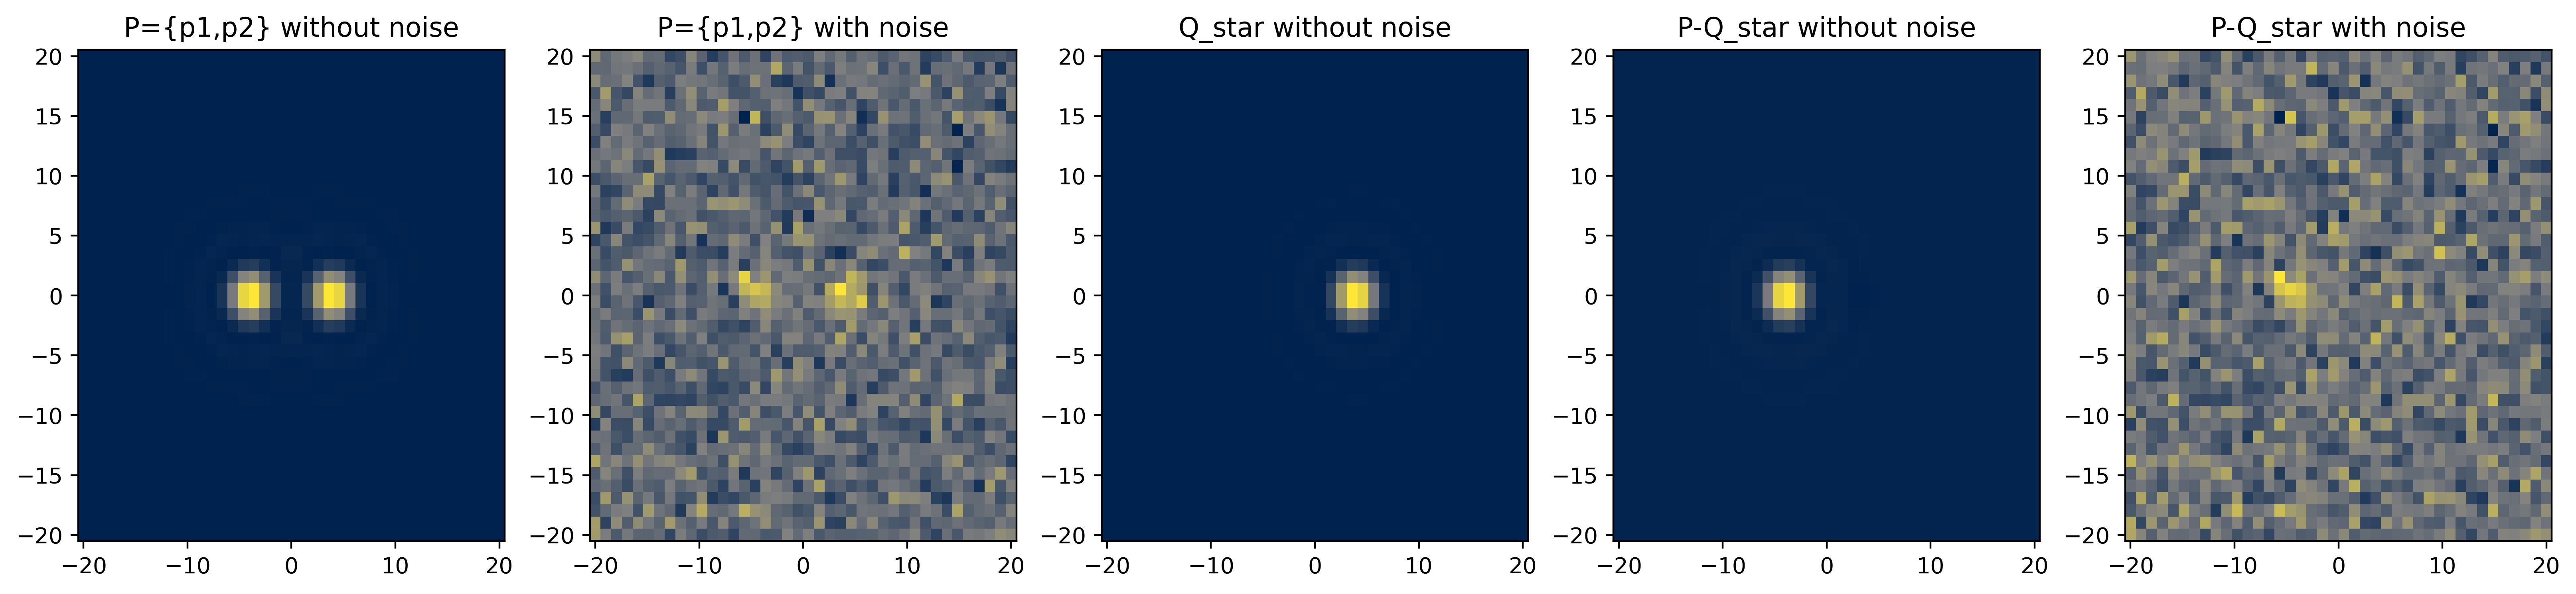

p_1 = (x = -3.928571428571429, y = 0, l = 7)
p_2 = (x = 3.928571428571429, y = 0, l = 7)
Q_star = (x = 3.912843489027694, y = 9.338630573250468e-17, l = 7.0777373903078775)
DoverJ = -0.9996031788812563  no contamination
J(P,Q_star) = 67.24610437983313
SNR = 11.66223133202165


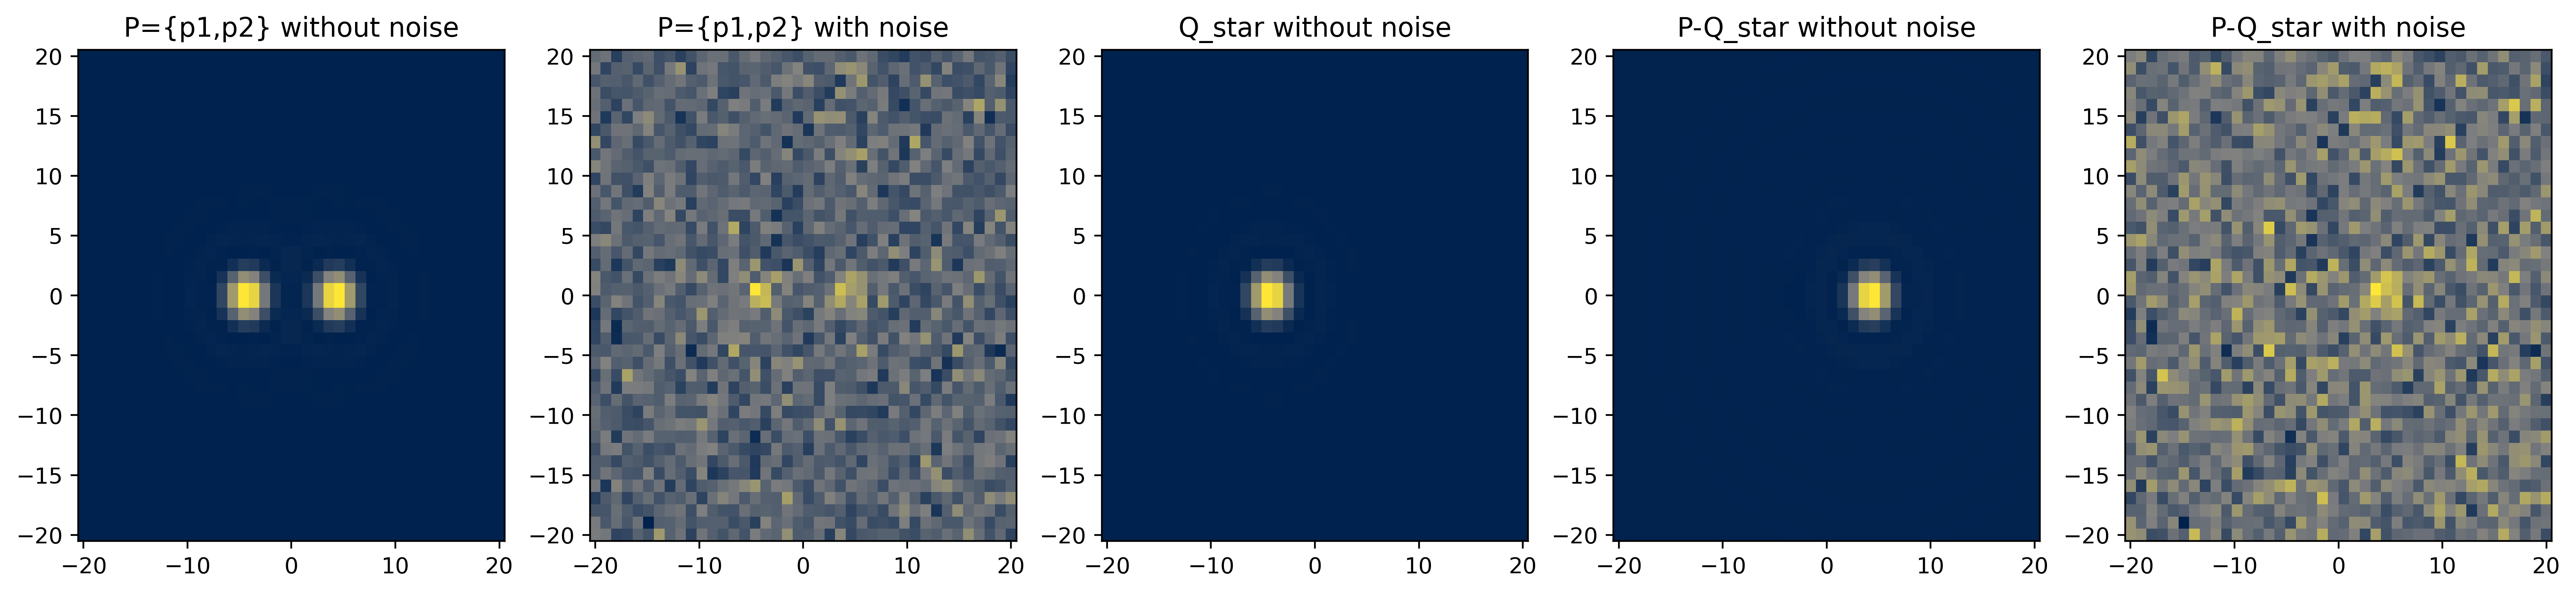

p_1 = (x = -4.285714285714286, y = 0, l = 7)
p_2 = (x = 4.285714285714286, y = 0, l = 7)
Q_star = (x = -4.2774845098186995, y = 4.2280711635221735e-17, l = 7.0603436771005)
DoverJ = -0.9998101325656276  no contamination
J(P,Q_star) = 67.25300298629212
SNR = 11.648046156997532


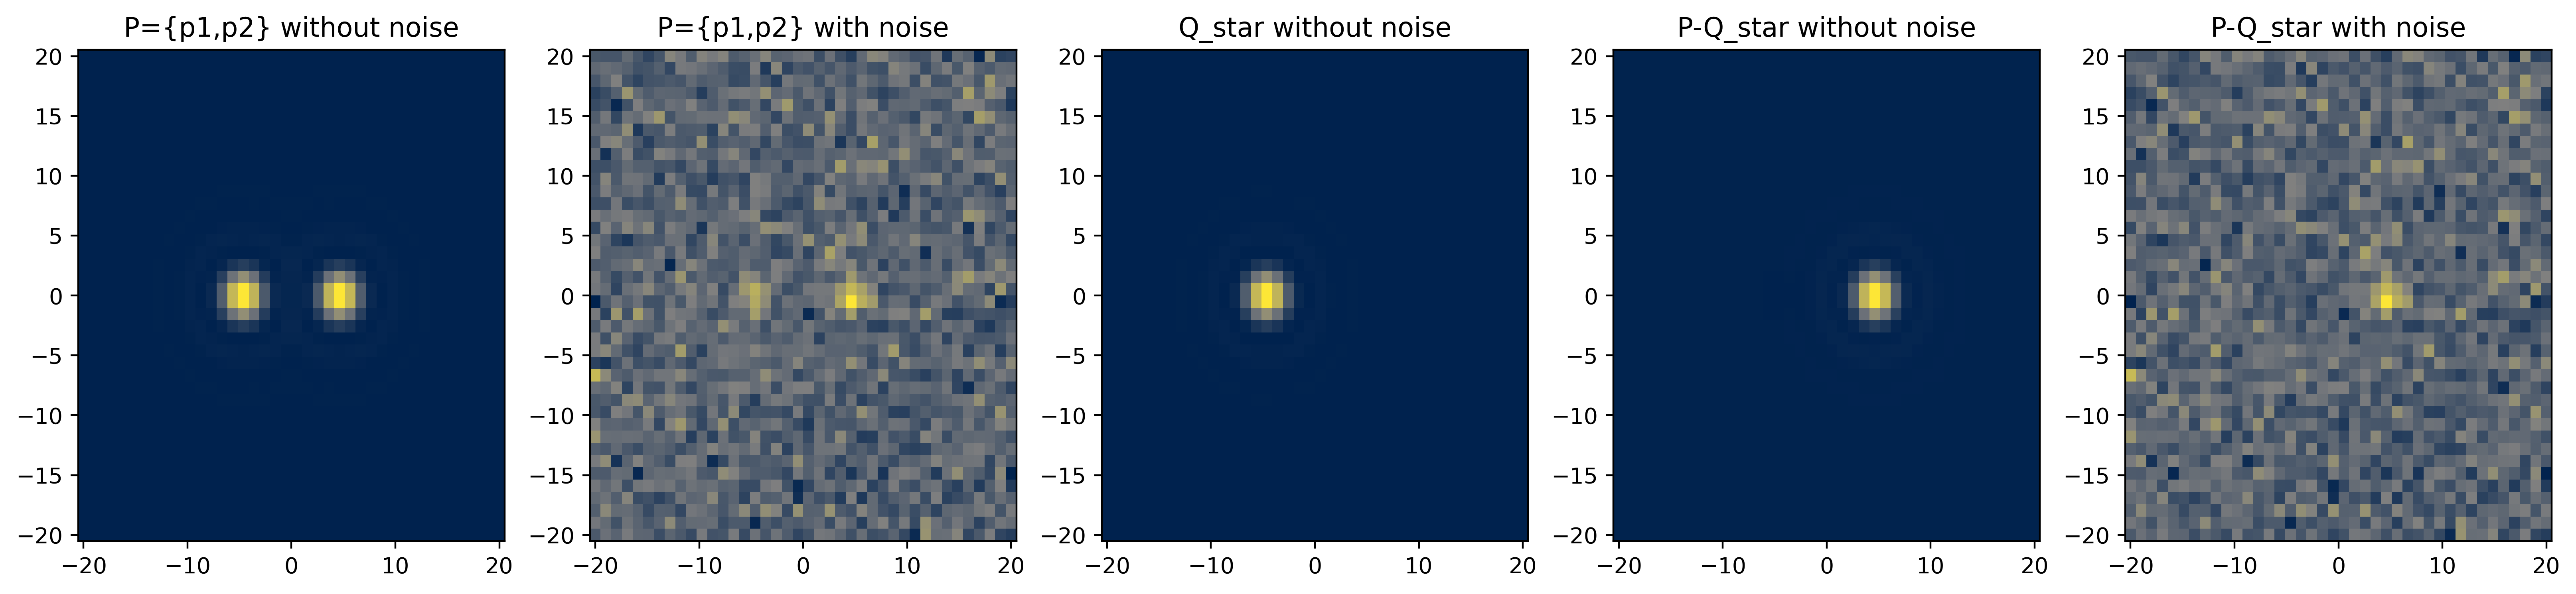

p_1 = (x = -4.642857142857143, y = 0, l = 7)
p_2 = (x = 4.642857142857143, y = 0, l = 7)
Q_star = (x = -4.636422390676118, y = 1.5670043093216652e-16, l = 7.049710470321802)
DoverJ = -0.9998738752363779  no contamination
J(P,Q_star) = 67.25512804451077
SNR = 11.639293047102802


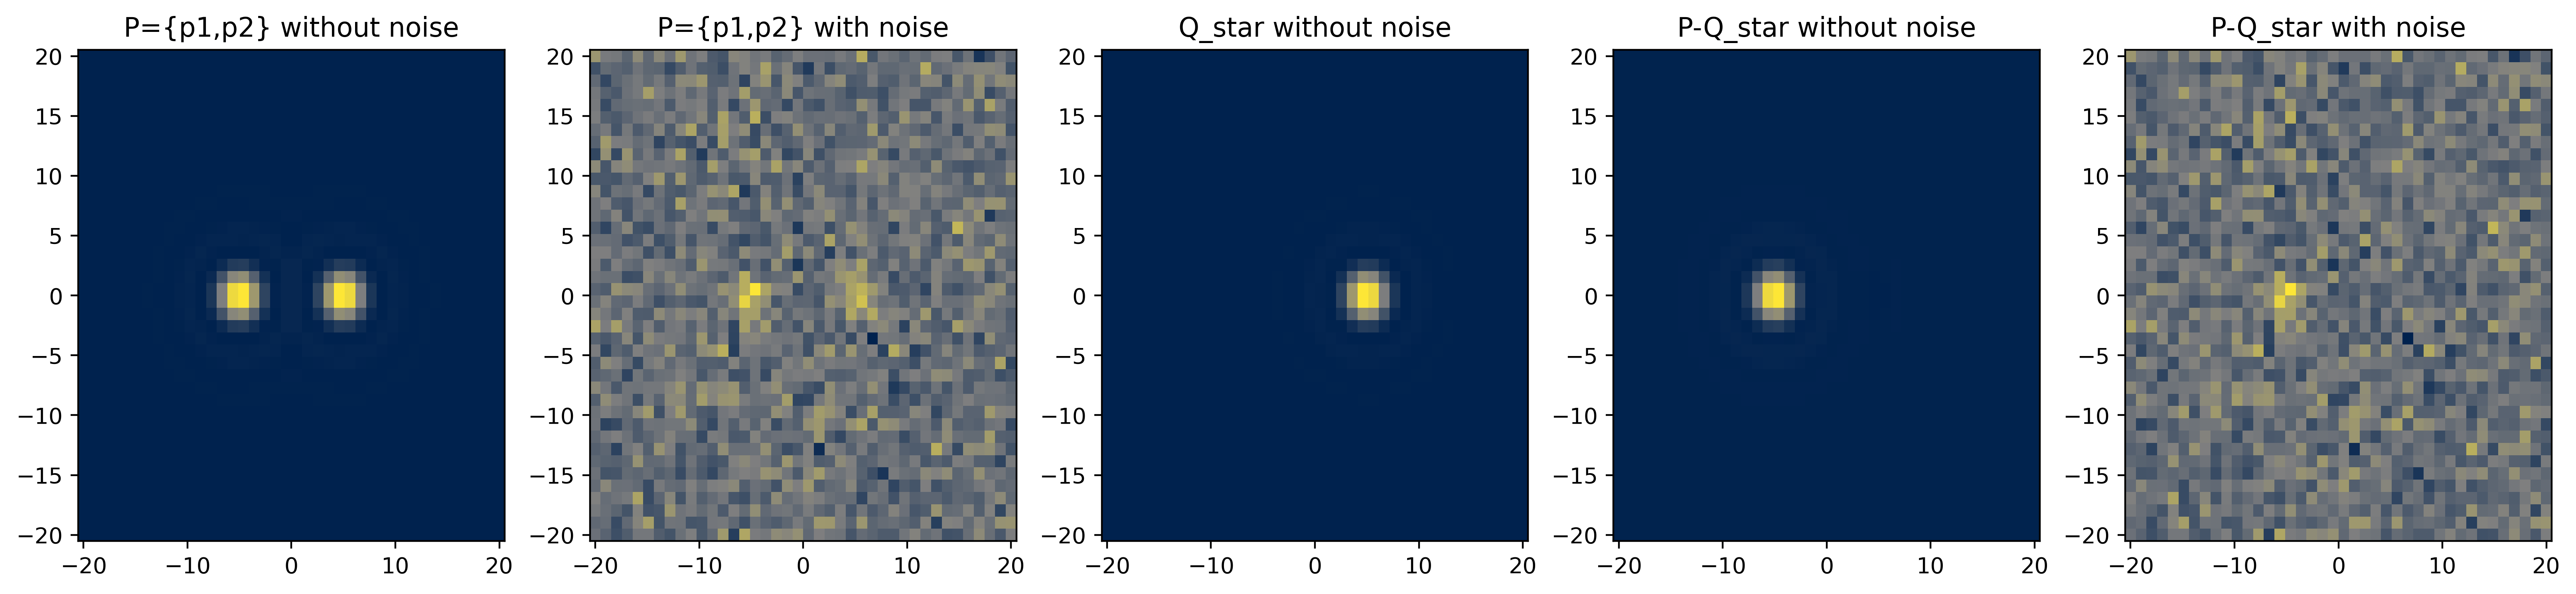

p_1 = (x = -5.0, y = 0, l = 7)
p_2 = (x = 5.0, y = 0, l = 7)
Q_star = (x = 4.993727833472186, y = -8.572178239799379e-17, l = 7.0399864299804635)
DoverJ = -0.9999107611632341  no contamination
J(P,Q_star) = 67.25635118374532
SNR = 11.631263221780317


In [41]:
# Computes Q_star, D (Target confusion value) and J(P,Q_star) for different distances between two point sources (P) distanced by x_test
x_tests = np.linspace(0,10,15)
data_test = [ get_x_star(-x_test/2,0,x_test/2,0,7,7) for x_test in x_tests ]

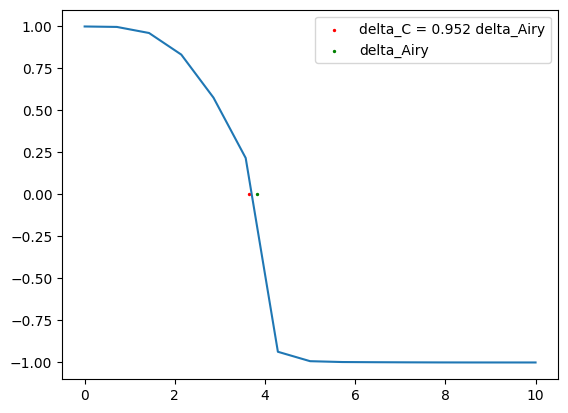

In [42]:
plt.plot(x_tests, np.array(data_test).T[-2])
#plt.plot(x_tests, np.array(data_test).T[-1])
plt.scatter(0.952*3.8317,0, s=2, color='red', label='delta_C = 0.952 delta_Airy')
plt.scatter(3.8317,0, s=2, color='green', label='delta_Airy')
plt.legend()
plt.show()

In [ ]:
# Computes D for many configurations of P, p1 is fixed at the origin and p2 moves in 2d field of view
x_tests = np.linspace(-8,8,20)
y_tests = np.linspace(-8,8,20)

# takes an 1 hour more or less
data_test = [[ get_x_star(0,0,x_test,y_test,7,7, plot =False) for x_test in x_tests ] for y_test in y_tests  ]

In [ ]:
fig, (ax0) = plt.subplots(1,1,figsize=(4,4), dpi=400)
x_mesh, y_mesh = np.meshgrid(x_tests, y_tests)
pm = ax0.pcolormesh( x_mesh, y_mesh, np.array(data_test).T[-2], cmap=cmap)
CS = ax0.contour( x_mesh, y_mesh, np.array(data_test).T[-2] , levels=np.array([0]), colors=['r'], linewidth=1)
ax0.set_xlabel(r'$\delta_x$')
ax0.set_ylabel(r'$\delta_y$')
ax0.title.set_text('Resolution map for l1/l2 = 1')
plt.show()
# not circular because of pixel size. in the limit of small pixel size the red line should describe a circle